# Profit and Loss Bootstrap Simulation (in trending sideways sample)

- Take the past 30 most recent days worth of historical data,
- take a bootstrap sample from the 2-minute log-returns,
- for each no-premium fee calculation (BSM, MC Normal, etc.)
- calculate the mean PnL of the sample and retain as bootstrap estimate _n_
- repeat N times
- take a look at the (mean) Profit and Loss distribution of each no-premium fee calculation methods
- and evaluate the results
- compare with-fees vs no-fees PnL

In [7]:

import math
import random as random

import pandas as pd

import numpy as np
from numpy.random import default_rng
np.set_printoptions(precision=5, suppress=True)

# fixes the seed for reproducibility
rng = default_rng(99)

import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy as scipy
from scipy.optimize import fsolve

import psycopg2

# import seaborn as sns

from math import log, sqrt, exp, pi
from scipy.stats import norm, laplace, t as student_t

# Markdown in code cell
from IPython.display import Markdown as md


plt.style.use('seaborn')
plt.colormaps
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'

# BSM Premium calculator
def bsm_premium(S0, K, T, sigma):
    # init
    r = 0.0
    # bsm terms
    d1 = (log(S0/K) + (r + 0.5 * sigma**2) * T) / sigma / sqrt(T)
    d2 = d1 - sigma * sqrt(T)
    N_d1 = norm.cdf(d1)
    N_d2 = norm.cdf(d2)
    
    # bsm premium
    BSM_premium = S0 * N_d1 - K * exp(-r*T) * N_d2
    
    return BSM_premium

# BSM Fee calculator
def bsm_no_premium_call_option_fee(S0, T, sigma):
    # BSM no-premium option strike calculator
    def bsm_no_premium_strike(S0, T, sigma):
        # init
        r = 0.0
        K_at_money = S0
        # bsm terms
        d1 = (log(S0/K_at_money) + (r + 0.5 * sigma**2) * T) / sigma / sqrt(T)
        d2 = d1 - sigma * sqrt(T)
        N_d1 = norm.cdf(d1)
        N_d2 = norm.cdf(d2)
        
        def bsm_premium(K):
            # bsm premium
            BSM_C0_no_premium = S0 * N_d1 - K * exp(-r*T) * N_d2
            return BSM_C0_no_premium
        
        K_no_premium = fsolve(bsm_premium, K_at_money)[0]
        
        return K_no_premium

    K_no_premium = bsm_no_premium_strike(S0, T, sigma)

    fee = (K_no_premium-S0)/S0

    return fee

# MC Normal Fee calculator
def mc_no_premium_call_option_fee(S0, T, sigma, I):
    # MC no-premium option strike calculator
    def mc_no_premium_strike(S0, T, sigma, I):
        # init
        r = 0.0
        K_at_money = S0

        # underlying price vector at maturity
        mc_rng = default_rng()
        ST = S0 * np.exp((r - sigma ** 2 / 2) * T + sigma * math.sqrt(T) * mc_rng.standard_normal(I))

        def mc_premium(K):
            # not exercised
            CT_below_K_at_money = ST[ST <= K_at_money] * 0

            # exercised at a loss
            CT_below_K = ST[ST > K_at_money]
            CT_below_K = CT_below_K[CT_below_K <= K] - K

            # exercised at a gain
            CT_above_K = ST[ST > K] - K

            # call option payoff at maturity
            CT_no_premium = np.concatenate((CT_below_K_at_money, CT_below_K, CT_above_K))

            CT_no_premium_mean = CT_no_premium.mean()

            # call option fair value
            MC_C0_no_premium = math.exp(-r * T) * CT_no_premium_mean

            return MC_C0_no_premium
        
        K_no_premium = fsolve(mc_premium, K_at_money)[0]
        
        return K_no_premium

    K_no_premium = mc_no_premium_strike(S0, T, sigma, I)

    fee = (K_no_premium-S0)/S0

    return fee

# MC Laplace Fee calculator
def mc_laplace_no_premium_call_option_fee(S0, T, loc, scale, I):
    # MC Laplace no-premium option strike calculator
    def mc_laplace_no_premium_strike(S0, T, loc, scale, I):
        # init
        r = 0.0
        K_at_money = S0

        # underlying price vector at maturity
        mc_rng = default_rng()
        ST = S0 * np.exp(laplace.rvs(loc, scale, size=I, random_state=99))

        def mc_premium(K):
            # not exercised
            CT_below_K_at_money = ST[ST <= K_at_money] * 0

            # exercised at a loss
            CT_below_K = ST[ST > K_at_money]
            CT_below_K = CT_below_K[CT_below_K <= K] - K

            # exercised at a gain
            CT_above_K = ST[ST > K] - K

            # call option payoff at maturity
            CT_no_premium = np.concatenate((CT_below_K_at_money, CT_below_K, CT_above_K))

            CT_no_premium_mean = CT_no_premium.mean()

            # call option fair value
            MC_C0_no_premium = math.exp(-r * T) * CT_no_premium_mean

            return MC_C0_no_premium
        
        K_no_premium = fsolve(mc_premium, K_at_money)[0]
        
        return K_no_premium

    K_no_premium = mc_laplace_no_premium_strike(S0, T, loc, scale, I)

    fee = (K_no_premium-S0)/S0

    return fee

# MC Student's t Fee calculator
def mc_student_t_no_premium_call_option_fee(S0, T, df, tloc, tscale, I):
    # MC Student's t no-premium option strike calculator
    def mc_student_t_no_premium_strike(S0, T, df, tloc, tscale, I):
        # init
        r = 0.0
        K_at_money = S0

        # underlying price vector at maturity
        mc_rng = default_rng()
        ST = S0 * np.exp(student_t.rvs(df, tloc, tscale, size=I, random_state=99))

        def mc_premium(K):
            # not exercised
            CT_below_K_at_money = ST[ST <= K_at_money] * 0

            # exercised at a loss
            CT_below_K = ST[ST > K_at_money]
            CT_below_K = CT_below_K[CT_below_K <= K] - K

            # exercised at a gain
            CT_above_K = ST[ST > K] - K

            # call option payoff at maturity
            CT_no_premium = np.concatenate((CT_below_K_at_money, CT_below_K, CT_above_K))

            CT_no_premium_mean = CT_no_premium.mean()

            # call option fair value
            MC_C0_no_premium = math.exp(-r * T) * CT_no_premium_mean

            return MC_C0_no_premium
        
        K_no_premium = fsolve(mc_premium, K_at_money)[0]
        
        return K_no_premium

    K_no_premium = mc_student_t_no_premium_strike(S0, T, df, tloc, tscale, I)

    fee = (K_no_premium-S0)/S0

    return fee

# Data set
btcusd_1min = pd.read_csv("./BTCUSD.csv", sep=",", header=0, names=["date","open","high","low","close"], index_col="date")

btcusd_1min['ret_2min'] = np.log(btcusd_1min['close'] / btcusd_1min['close'].shift(2))

# Using the most recent 30 days worth of data only
nb_2min_in_30d = 30*24*30 # = 21600
# # trend up (mostly)
# ret_2min = btcusd_1min['ret_2min'][-11*21600:-10*21600]
# # trend down (mostly)
# ret_2min = btcusd_1min['ret_2min'][-3*21600:-2*21600]
# trend sideways (mostly)
ret_2min = btcusd_1min['ret_2min'][-1*21600:]

# the 2-min vol
vol_2min = ret_2min.std()

# number of 2-minute per year
nb_2min_per_year = 60/2 * 24 * 365.25
vol_ann = vol_2min * sqrt(nb_2min_per_year)


## Preview of the data sample in price and returns

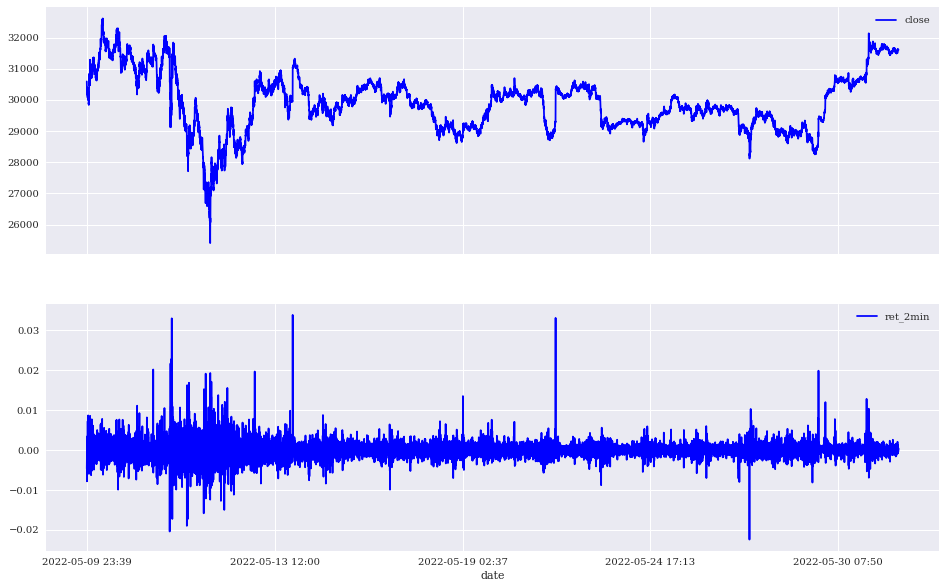

In [8]:

# trend up (mostly)
# btcusd_1min[['close', 'ret_2min']][-11*21600:-10*21600].plot(subplots=True, style='b', figsize=(16, 10))

# trend down (mostly)
# btcusd_1min[['close', 'ret_2min']][-3*21600:-2*21600].plot(subplots=True, style='b', figsize=(16, 10))

# trend sideways (mostly)
btcusd_1min[['close', 'ret_2min']][-1*21600:].plot(subplots=True, style='b', figsize=(16, 10))

plt.show()

In [9]:

# underlying price at t=0
S0 = 30_000.00

# risk free rate (no present value discounting)
r = 0.0

# 2min yearly fraction
T = 1 / (60/2 * 24 * 365.25)

# annualized 2min volatility
sigma = vol_ann

# number of price simulations
I = 1_000_000

# sample size
N = nb_2min_in_30d

# sample size
N_boot = 5000

header = '''|variable|value|
|:-:|-:|'''

table = ""
table += f"|S(0)|{float('%.8g' % S0)} USD|\n"
table += f"|T|{float('%.3g' % T)}|\n"
table += f"|r|{r}|\n"
table += f"|σ|{float('%.5g' % (sigma*100))}%|\n"
table += f"|I|{I}|\n"

table2 = ""
table2 += f"|Samples| most recent 30 days|\n"
table2 += f"|N|{N}|\n"

table3 = ""
table3 += f"|Boostrap Iterations|{N_boot}|\n"

md(f"""### Simulation variables
{header}
{table}
{header}
{table2}
{header}
{table3}
""")


### Simulation variables
|variable|value|
|:-:|-:|
|S(0)|30000.0 USD|
|T|3.8e-06|
|r|0.0|
|σ|107.01%|
|I|1000000|

|variable|value|
|:-:|-:|
|Samples| most recent 30 days|
|N|21600|

|variable|value|
|:-:|-:|
|Boostrap Iterations|5000|



In [10]:

# for N times repeat this

# new bootstrapped underlying price vector from historical 2-minute log-returns
ret_2min_boot = np.array(random.choices(ret_2min, k=ret_2min.size))
ST = S0 * np.exp(ret_2min_boot)

# BSM volatility
vol_2min_boot = ret_2min_boot.std()
vol_ann = vol_2min_boot * sqrt(nb_2min_per_year)
sigma = vol_ann

# bootstrap sample stats
mean = ret_2min_boot.mean()
std = ret_2min_boot.std()

# Fit the Normal PDF.
m,s = norm.fit(ret_2min_boot)

# Fit the Laplace PDF.
loc,scale = laplace.fit(ret_2min_boot)

# Fit the Student's t PDF.
df, tloc, tscale = student_t.fit(ret_2min_boot)

# calc the exercised prices
ST_exercised = ST[ST > S0]

# calc bsm at the money premium
bsm_c0 = bsm_premium(S0, S0, T, sigma)

# calc bsm fee
bsm_fee = bsm_no_premium_call_option_fee(S0, T, sigma)
# calc bsm strike
bsm_strike = S0 * (1 + bsm_fee)
# calc bsm option payoffs
bsm_at_the_money_ct = ST_exercised - S0
# calc bsm pnl
bsm_at_the_money_pnl = -bsm_at_the_money_ct
# calc bsm option payoffs
bsm_ct = ST_exercised - bsm_strike
# calc bsm pnl
bsm_pnl = -bsm_ct

# calc mc normal fee
mc_normal_fee = mc_no_premium_call_option_fee(S0, T, sigma, I)
# calc mc normal strike
mc_normal_strike = S0 * (1 + mc_normal_fee)
# calc mc normal option payoffs
mc_normal_ct = ST_exercised - mc_normal_strike
# calc mc normal pnl
mc_normal_pnl = -mc_normal_ct # i.e. get the no-premium strike at the cost of the terminal price

# calc mc laplace fee
mc_laplace_fee = mc_laplace_no_premium_call_option_fee(S0, T, loc, scale, I)
# calc mc laplace strike
mc_laplace_strike = S0 * (1 + mc_laplace_fee)
# calc mc laplace option payoffs
mc_laplace_ct = ST_exercised - mc_laplace_strike
# calc mc laplace pnl
mc_laplace_pnl = -mc_laplace_ct

# calc mc student's t fee
mc_student_t_fee = mc_student_t_no_premium_call_option_fee(S0, T, df, tloc, tscale, I)
# calc mc student's t strike
mc_student_t_strike = S0 * (1 + mc_student_t_fee)
# calc mc student's t option payoffs
mc_student_t_ct = ST_exercised - mc_student_t_strike
# calc mc student's t pnl
mc_student_t_pnl = -mc_student_t_ct




## Preview of one iteration

In [11]:


header = '''|variable|value|
|:-:|-:|'''

table = ""
table += f"|Sample mean|{float('%.5g' % mean)}|\n"
table += f"|Sample std|{float('%.5g' % std)}|\n"
table += f"|σ|{float('%.5g' % (sigma*100))}%|\n"
table += f"|Normal mean|{float('%.5g' % m)}|\n"
table += f"|Normal std|{float('%.5g' % s)}|\n"
table += f"|Normal std/sqrt(2)|{float('%.5g' % (std/sqrt(2)))}|\n"
# table += f"|Laplace scale*sqrt(2)|{float('%.5g' % (scale*sqrt(2)))}|\n"
table += f"|Laplace scale|{float('%.5g' % scale)}|\n"
table += f"|Laplace location|{float('%.5g' % loc)}|\n"
table += f"|Student's t df|{float('%.5g' % df)}|\n"
table += f"|Student's t location|{float('%.5g' % tloc)}|\n"
table += f"|Student's t scale|{float('%.5g' % tscale)}|\n"

table2 = ""
table2 += f"|BSM strike|{float('%.7g' % bsm_strike)} USD|\n"
table2 += f"|MC Normal strike|{float('%.7g' % mc_normal_strike)} USD|\n"
table2 += f"|MC Laplace strike|{float('%.7g' % mc_laplace_strike)} USD|\n"
table2 += f"|MC Student's t strike|{float('%.7g' % mc_student_t_strike)} USD|\n"

table3 = ""
table3 += f"|BSM fee|{float('%.5g' % (bsm_fee*100))}%|\n"
table3 += f"|MC Normal fee|{float('%.5g' % (mc_normal_fee*100))}%|\n"
table3 += f"|MC Laplace fee|{float('%.5g' % (mc_laplace_fee*100))}%|\n"
table3 += f"|MC Student's t fee|{float('%.5g' % (mc_student_t_fee*100))}%|\n"

table4 = ""
table4 += f"|BSM premuim|{float('%.4g' % bsm_c0)} USD|\n"

md(f"""### Data fitting stats
{header}
{table}
### At-the-money Premium
{header}
{table4}
### Calculated Strikes
{header}
{table2}
### Calculated Fees
{header}
{table3}
""")


### Data fitting stats
|variable|value|
|:-:|-:|
|Sample mean|-3.6328e-06|
|Sample std|0.0021219|
|σ|108.81%|
|Normal mean|-3.6328e-06|
|Normal std|0.0021219|
|Normal std/sqrt(2)|0.0015004|
|Laplace scale|0.0012985|
|Laplace location|-2.9344e-05|
|Student's t df|2.0034|
|Student's t location|-3.9052e-05|
|Student's t scale|0.001003|

### At-the-money Premium
|variable|value|
|:-:|-:|
|BSM premuim|25.4 USD|

### Calculated Strikes
|variable|value|
|:-:|-:|
|BSM strike|30050.83 USD|
|MC Normal strike|30050.88 USD|
|MC Laplace strike|30038.92 USD|
|MC Student's t strike|30043.79 USD|

### Calculated Fees
|variable|value|
|:-:|-:|
|BSM fee|0.16944%|
|MC Normal fee|0.16959%|
|MC Laplace fee|0.12975%|
|MC Student's t fee|0.14596%|



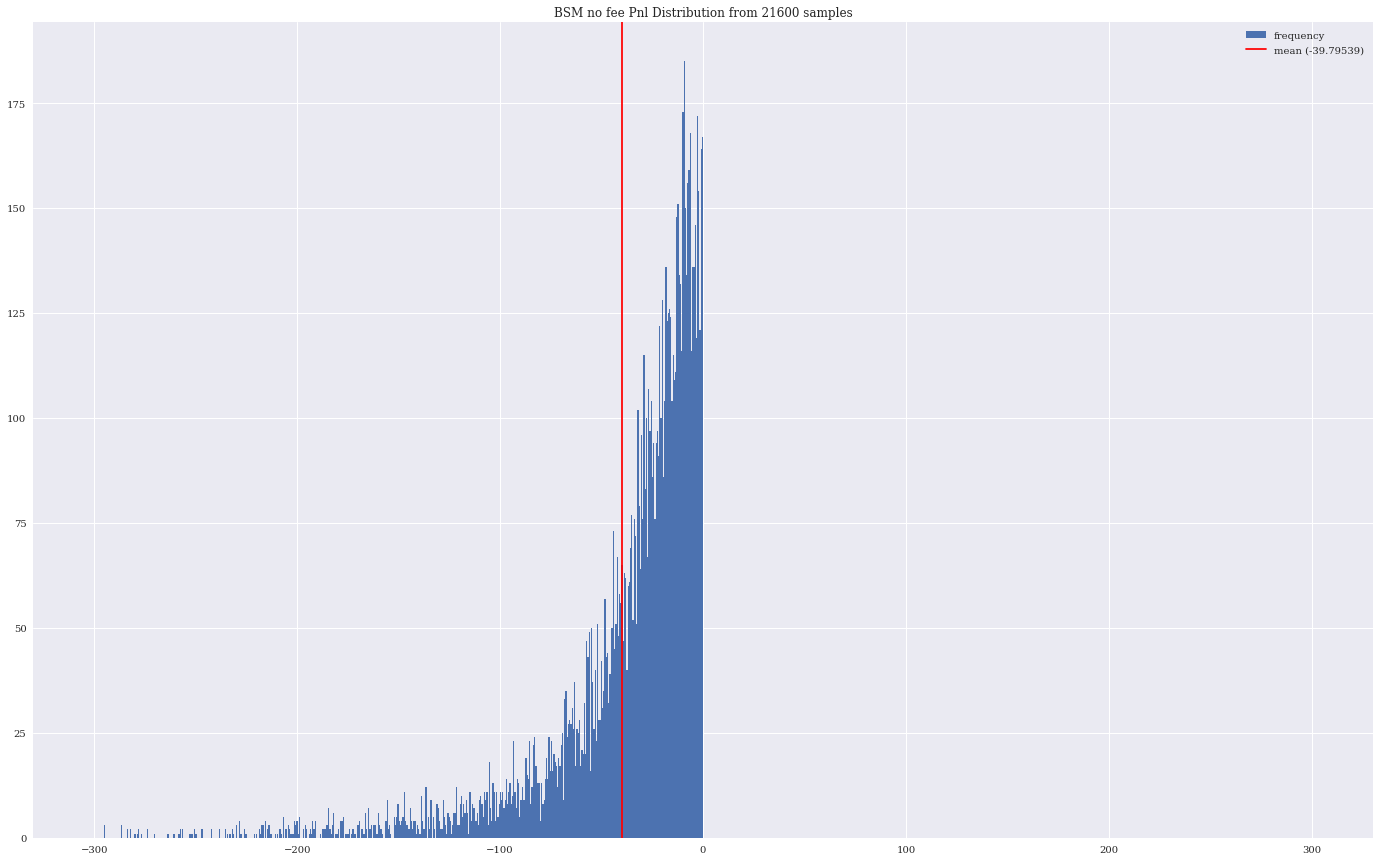

In [12]:

plt.figure(figsize=(24, 15))
plt.hist(bsm_at_the_money_pnl, bins=1000, label='frequency', range=[-S0*.01, S0*0.01]);

plt.axvline(bsm_at_the_money_pnl.mean(), color='r', label=f"mean ({float('%.7g' % (bsm_at_the_money_pnl.mean()))})")

plt.title(f'BSM no fee Pnl Distribution from {N} samples')
plt.legend(loc='best');
plt.show()

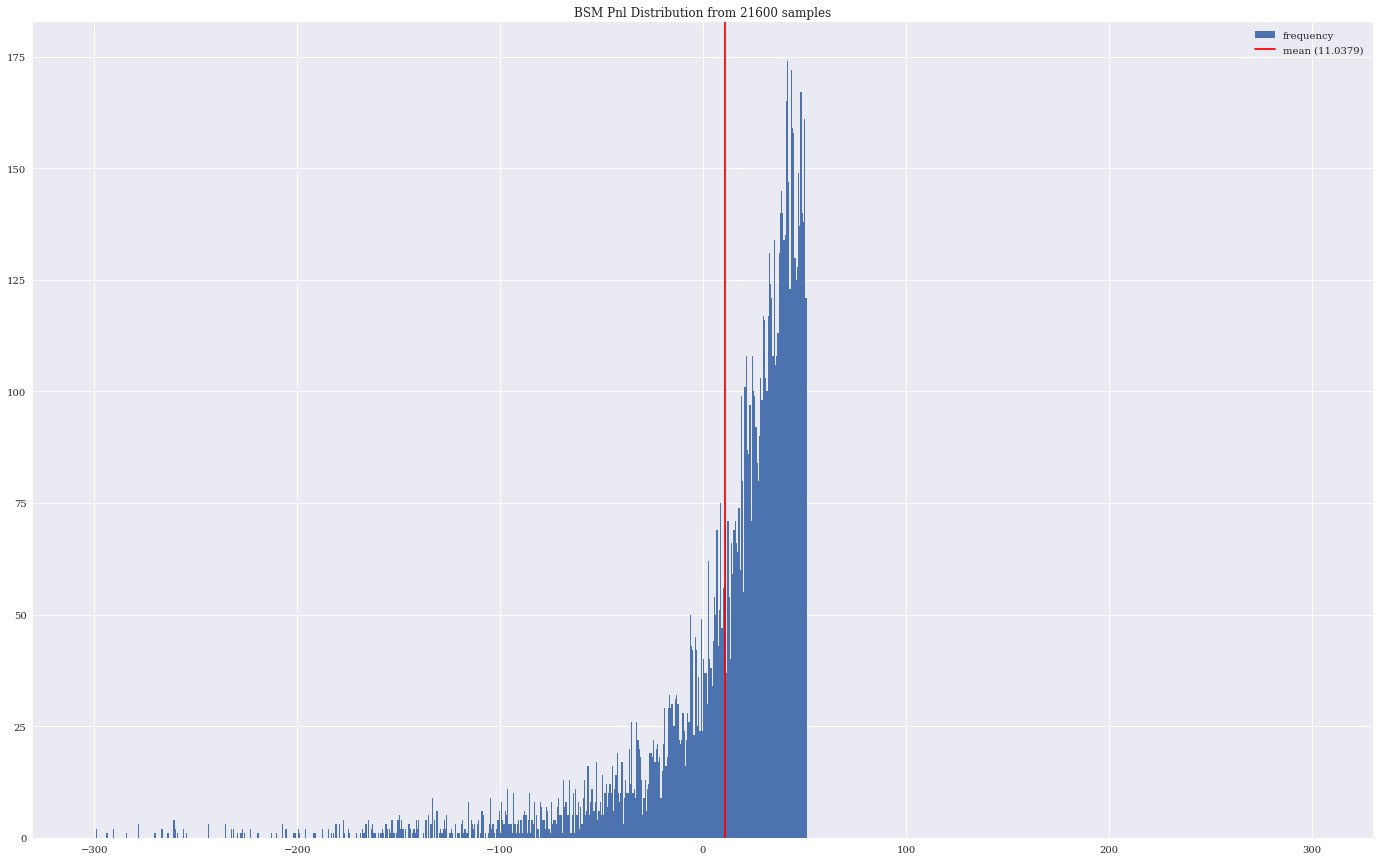

In [13]:

plt.figure(figsize=(24, 15))
plt.hist(bsm_pnl, bins=1000, label='frequency', range=[-S0*.01, S0*0.01]);

plt.axvline(bsm_pnl.mean(), color='r', label=f"mean ({float('%.7g' % (bsm_pnl.mean()))})")

plt.title(f'BSM Pnl Distribution from {N} samples')
plt.legend(loc='best');
plt.show()

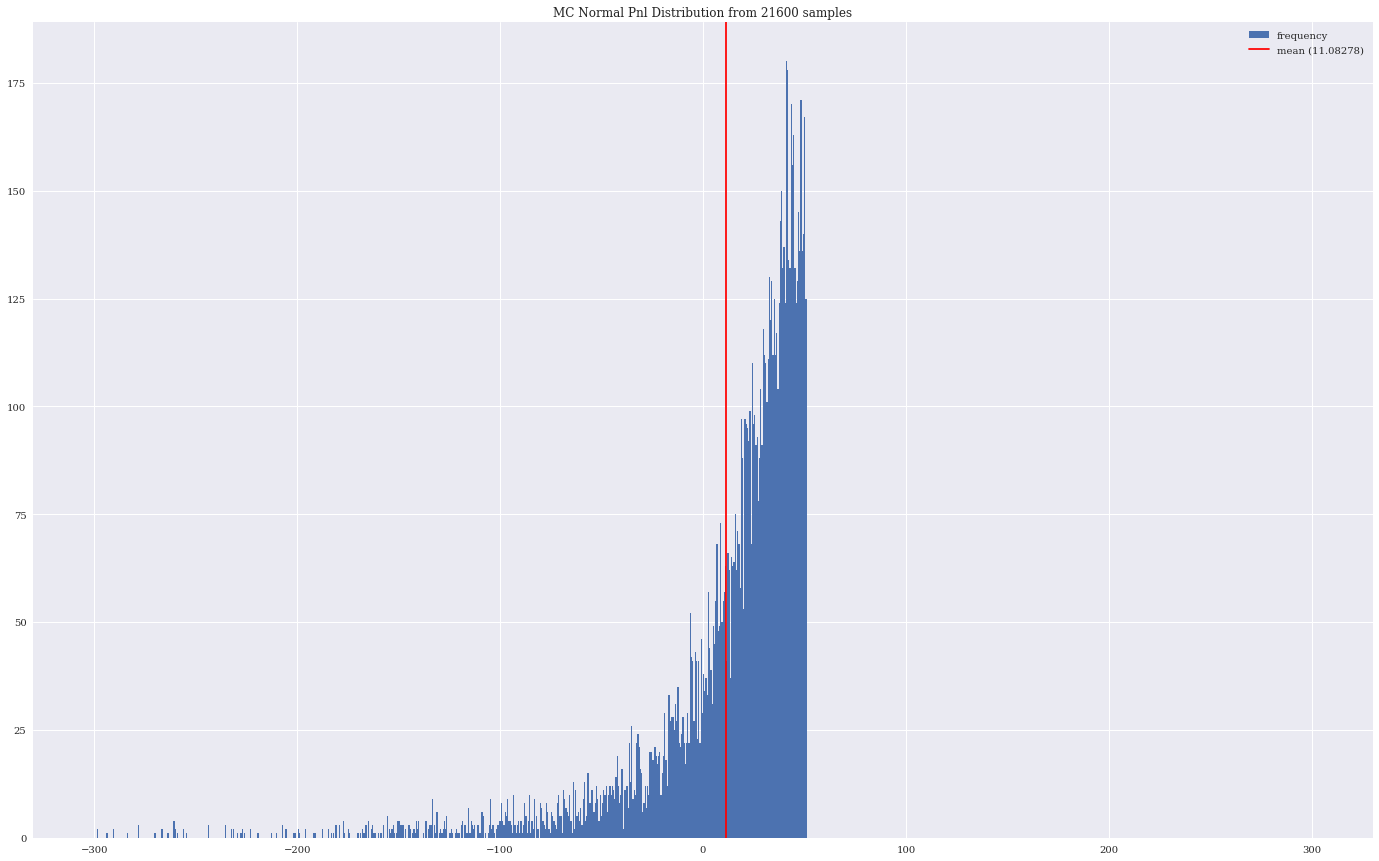

In [14]:

plt.figure(figsize=(24, 15))
plt.hist(mc_normal_pnl, bins=1000, label='frequency', range=[-S0*.01, S0*0.01]);

plt.axvline(mc_normal_pnl.mean(), color='r', label=f"mean ({float('%.7g' % (mc_normal_pnl.mean()))})")

plt.title(f'MC Normal Pnl Distribution from {N} samples')
plt.legend(loc='best');
plt.show()

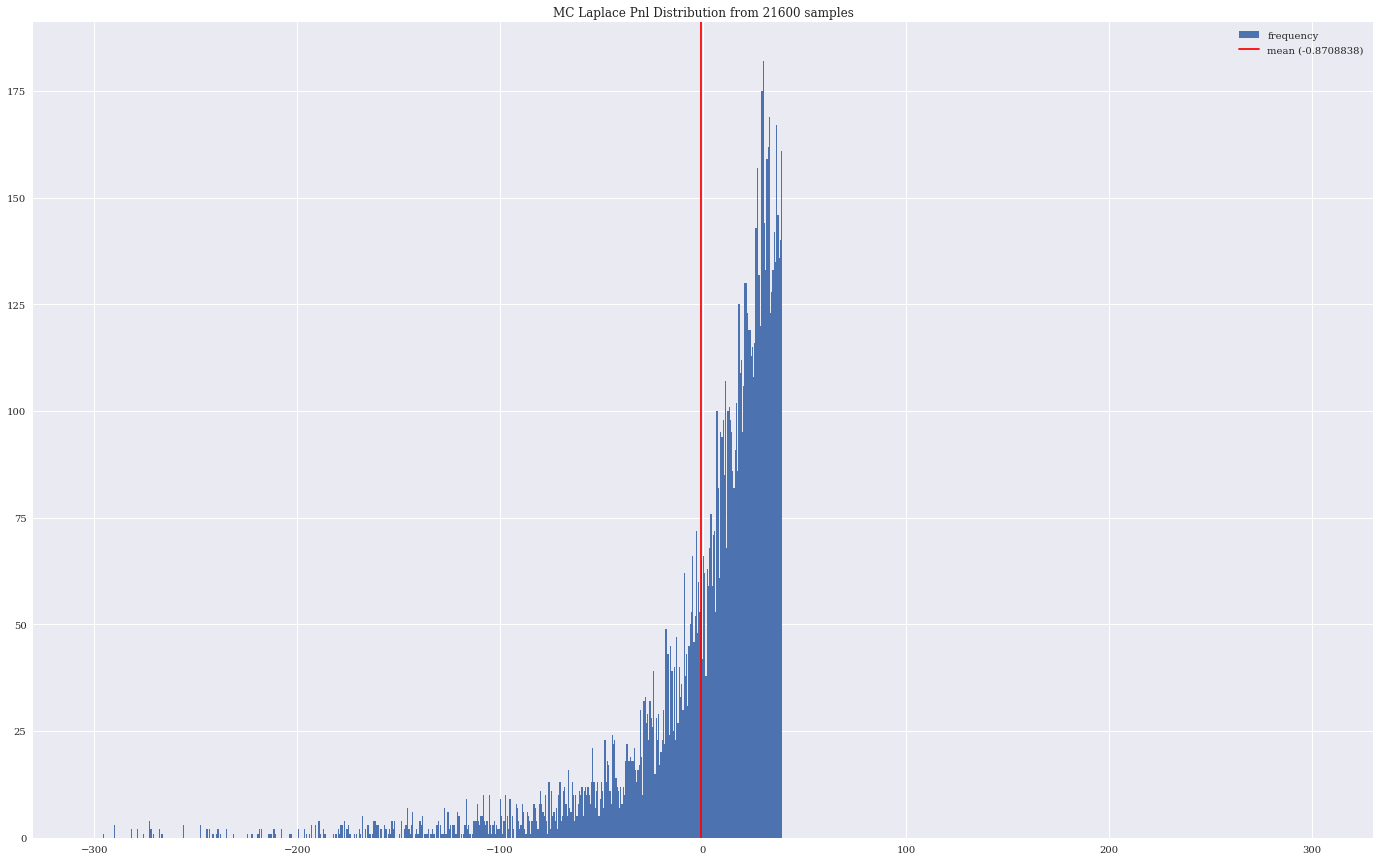

In [15]:

plt.figure(figsize=(24, 15))
plt.hist(mc_laplace_pnl, bins=1000, label='frequency', range=[-S0*.01, S0*0.01]);

plt.axvline(mc_laplace_pnl.mean(), color='r', label=f"mean ({float('%.7g' % (mc_laplace_pnl.mean()))})")

plt.title(f'MC Laplace Pnl Distribution from {N} samples')
plt.legend(loc='best');
plt.show()

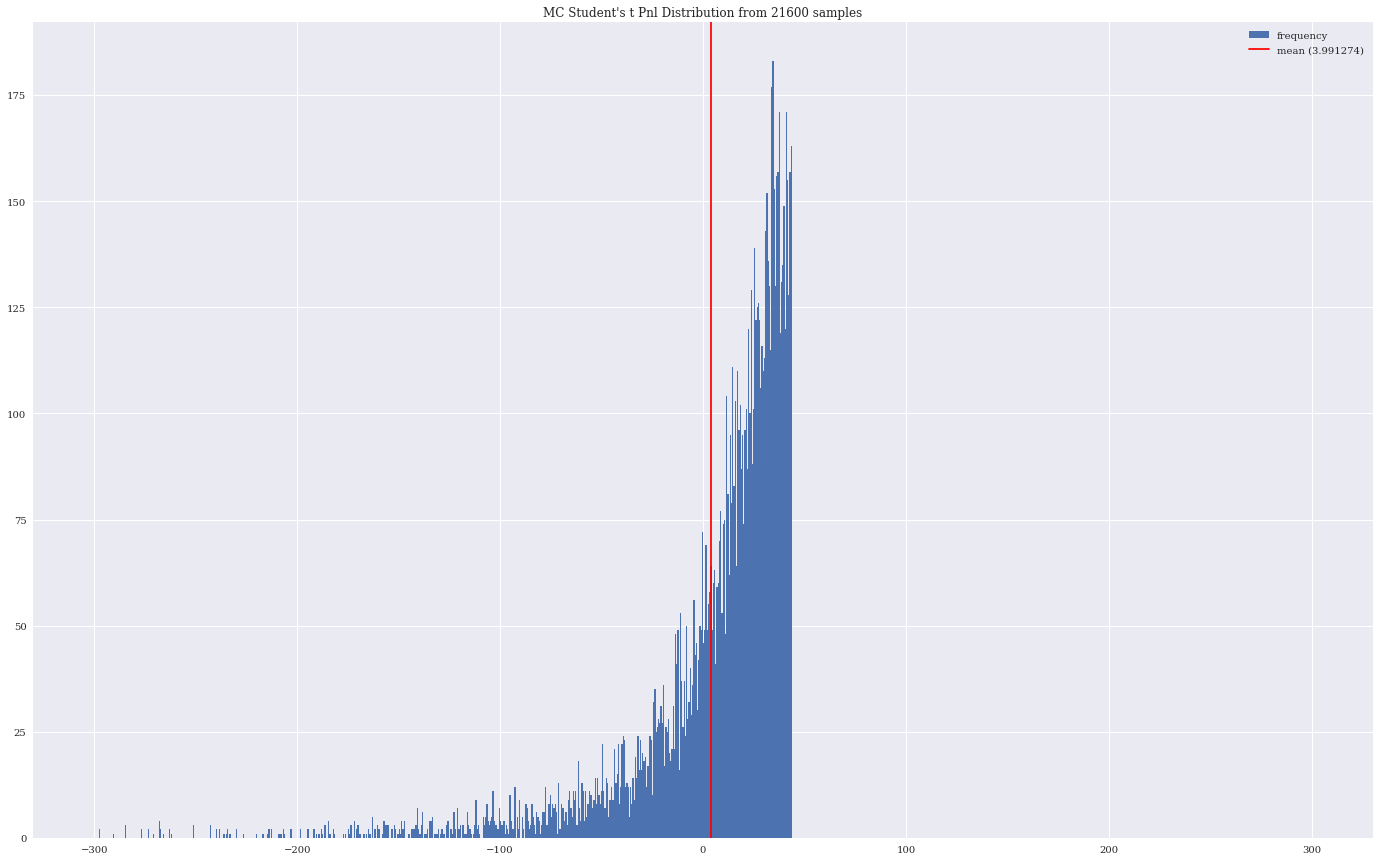

In [16]:

plt.figure(figsize=(24, 15))
plt.hist(mc_student_t_pnl, bins=1000, label='frequency', range=[-S0*.01, S0*0.01]);

plt.axvline(mc_student_t_pnl.mean(), color='r', label=f"mean ({float('%.7g' % (mc_student_t_pnl.mean()))})")

plt.title(f"MC Student's t Pnl Distribution from {N} samples")
plt.legend(loc='best');
plt.show()

## Bootstrap results


In [17]:
# define bootstrap per iteration task

# init pnl bootstrap distribution
bsm_at_the_money_pnl_boot = np.zeros(N_boot)
bsm_pnl_boot = np.zeros(N_boot)
mc_normal_pnl_boot = np.zeros(N_boot)
mc_laplace_pnl_boot = np.zeros(N_boot)
mc_student_t_pnl_boot = np.zeros(N_boot)

# bootstrap per iteration task
def bootstrap(i):
    # new bootstrapped underlying price vector from historical 2-minute log-returns
    ret_2min_boot = np.array(random.choices(ret_2min, k=ret_2min.size))
    ST = S0 * np.exp(ret_2min_boot)

    # BSM volatility
    vol_2min_boot = ret_2min_boot.std()
    vol_ann = vol_2min_boot * sqrt(nb_2min_per_year)

    # bootstrap sample stats
    mean = ret_2min_boot.mean()
    std = ret_2min_boot.std()

    # Fit the Normal PDF.
    m,s = norm.fit(ret_2min_boot)

    # Fit the Laplace PDF.
    loc,scale = laplace.fit(ret_2min_boot)

    # Fit the Student's t PDF.
    df, tloc, tscale = student_t.fit(ret_2min_boot)

    # calc the exercised prices
    ST_exercised = ST[ST > S0]

    # calc bsm at-the-money option payoffs
    bsm_at_the_money_ct = ST_exercised - S0
    # calc bsm at-the-money pnl
    bsm_at_the_money_pnl = -bsm_at_the_money_ct
    # append bsm at-the-money bootstrap estimate
    bsm_at_the_money_pnl_boot[i] = bsm_at_the_money_pnl.mean()

    # calc bsm fee
    bsm_fee = bsm_no_premium_call_option_fee(S0, T, sigma)
    # calc bsm strike
    bsm_strike = S0 * (1 + bsm_fee)
    # calc bsm option payoffs
    bsm_ct = ST_exercised - bsm_strike
    # calc bsm pnl
    bsm_pnl = -bsm_ct
    # append bsm bootstrap estimate
    bsm_pnl_boot[i] = bsm_pnl.mean()

    # calc mc normal fee
    mc_normal_fee = mc_no_premium_call_option_fee(S0, T, sigma, I)
    # calc mc normal strike
    mc_normal_strike = S0 * (1 + mc_normal_fee)
    # calc mc normal option payoffs
    mc_normal_ct = ST_exercised - mc_normal_strike
    # calc mc normal pnl
    mc_normal_pnl = -mc_normal_ct
    # append bsm bootstrap estimate
    mc_normal_pnl_boot[i] = mc_normal_pnl.mean()

    # calc mc laplace fee
    mc_laplace_fee = mc_laplace_no_premium_call_option_fee(S0, T, loc, scale, I)
    # calc mc laplace strike
    mc_laplace_strike = S0 * (1 + mc_laplace_fee)
    # calc mc laplace option payoffs
    mc_laplace_ct = ST_exercised - mc_laplace_strike
    # calc mc laplace pnl
    mc_laplace_pnl = -mc_laplace_ct
    # append bsm bootstrap estimate
    mc_laplace_pnl_boot[i] = mc_laplace_pnl.mean()

    # calc mc student's t fee
    mc_student_t_fee = mc_student_t_no_premium_call_option_fee(S0, T, df, tloc, tscale, I)
    # calc mc student's t strike
    mc_student_t_strike = S0 * (1 + mc_student_t_fee)
    # calc mc student's t option payoffs
    mc_student_t_ct = ST_exercised - mc_student_t_strike
    # calc mc student's t pnl
    mc_student_t_pnl = -mc_student_t_ct
    # append bsm bootstrap estimate
    mc_student_t_pnl_boot[i] = mc_student_t_pnl.mean()

    return


In [18]:
# parallelize bootstrap loop

from joblib import Parallel, delayed
import multiprocessing

# parallel bootstrap
num_cores = multiprocessing.cpu_count()
void = Parallel(n_jobs=(num_cores-1), require='sharedmem')(delayed(bootstrap)(i) for i in range(N_boot))


In [19]:
def calc_basic_confidence_interval(percentile, data):
    mean = data.mean()
    percentile_lo = np.percentile(data, 100*(1-percentile/2))
    percentile_hi = np.percentile(data, 100*(percentile/2))
    ci_lo = 2*mean - percentile_lo
    ci_hi = 2*mean - percentile_hi
    return [ci_lo, mean, ci_hi]

In [20]:
# calc basic bootstrap confidence interval
percentile = 0.99

[bsm_at_the_money_pnl_boot_mean_ci_lo, bsm_at_the_money_pnl_boot_mean, bsm_at_the_money_pnl_boot_mean_ci_hi] = calc_basic_confidence_interval(percentile, bsm_at_the_money_pnl_boot)
[bsm_pnl_boot_mean_ci_lo, bsm_pnl_boot_mean, bsm_pnl_boot_mean_ci_hi] = calc_basic_confidence_interval(percentile, bsm_pnl_boot)
[mc_normal_pnl_boot_mean_ci_lo, mc_normal_pnl_boot_mean, mc_normal_pnl_boot_mean_ci_hi] = calc_basic_confidence_interval(percentile, mc_normal_pnl_boot)
[mc_laplace_pnl_boot_mean_ci_lo, mc_laplace_pnl_boot_mean, mc_laplace_pnl_boot_mean_ci_hi] = calc_basic_confidence_interval(percentile, mc_laplace_pnl_boot)
[mc_student_t_pnl_boot_mean_ci_lo, mc_student_t_pnl_boot_mean, mc_student_t_pnl_boot_mean_ci_hi] = calc_basic_confidence_interval(percentile, mc_student_t_pnl_boot)


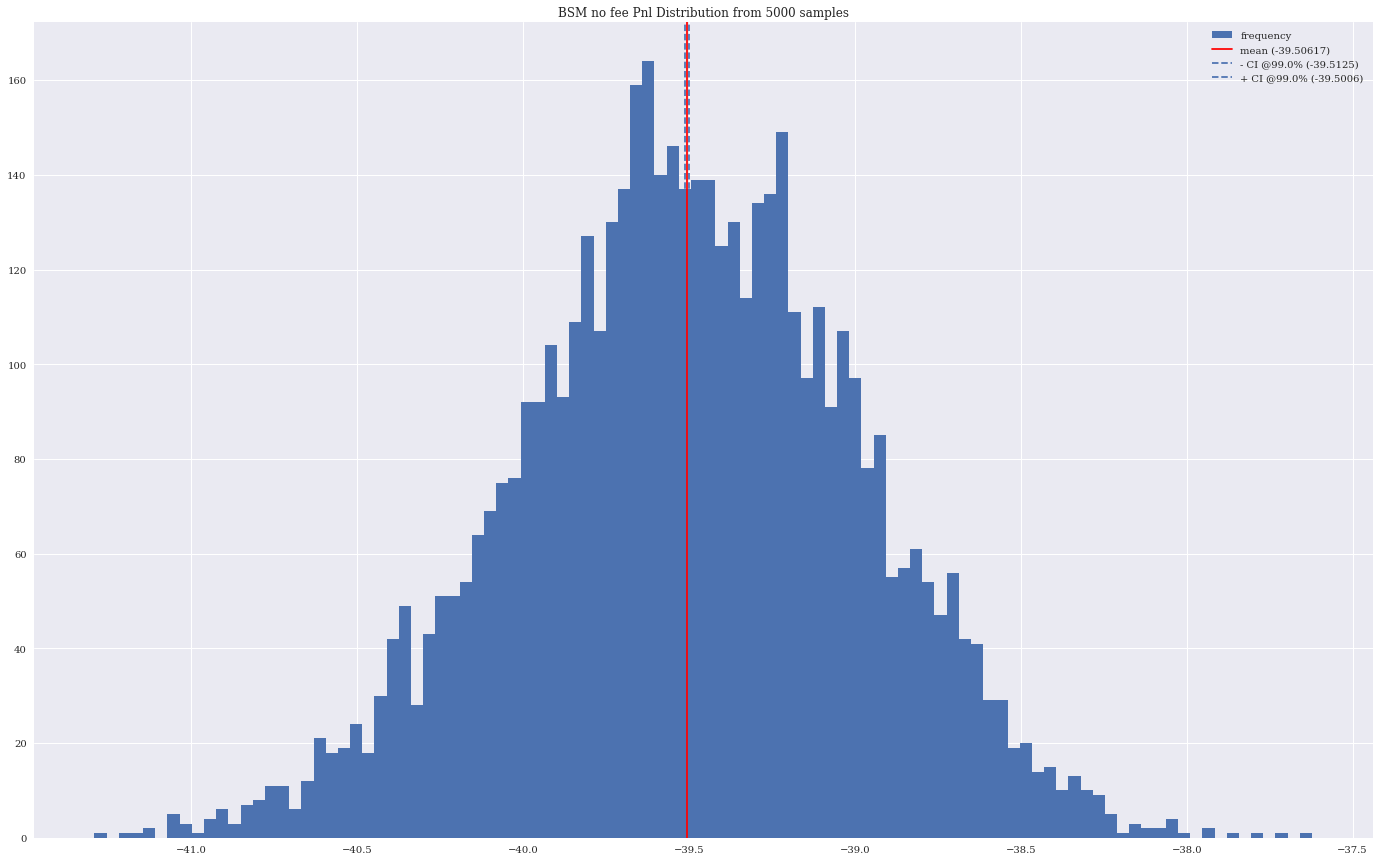

In [21]:

plt.figure(figsize=(24, 15))
# plt.hist(bsm_at_the_money_pnl_boot, bins=1000, label='frequency', range=[-S0*.01, S0*0.01]);
plt.hist(bsm_at_the_money_pnl_boot, bins=100, label='frequency');
# plt.hist(bsm_at_the_money_pnl_boot, bins=100, label='frequency', range=[-S0*.002, S0*0.002]);

plt.axvline(bsm_at_the_money_pnl_boot_mean, color='r', label=f"mean ({float('%.7g' % (bsm_at_the_money_pnl_boot_mean))})")
plt.axvline(bsm_at_the_money_pnl_boot_mean_ci_lo, label=f'- CI @{percentile*100}% ({(bsm_at_the_money_pnl_boot_mean_ci_lo).round(4)})', linestyle='--')
plt.axvline(bsm_at_the_money_pnl_boot_mean_ci_hi, label=f'+ CI @{percentile*100}% ({(bsm_at_the_money_pnl_boot_mean_ci_hi).round(4)})', linestyle='--')

plt.title(f'BSM no fee Pnl Distribution from {N_boot} samples')
plt.legend(loc='best');
plt.show()

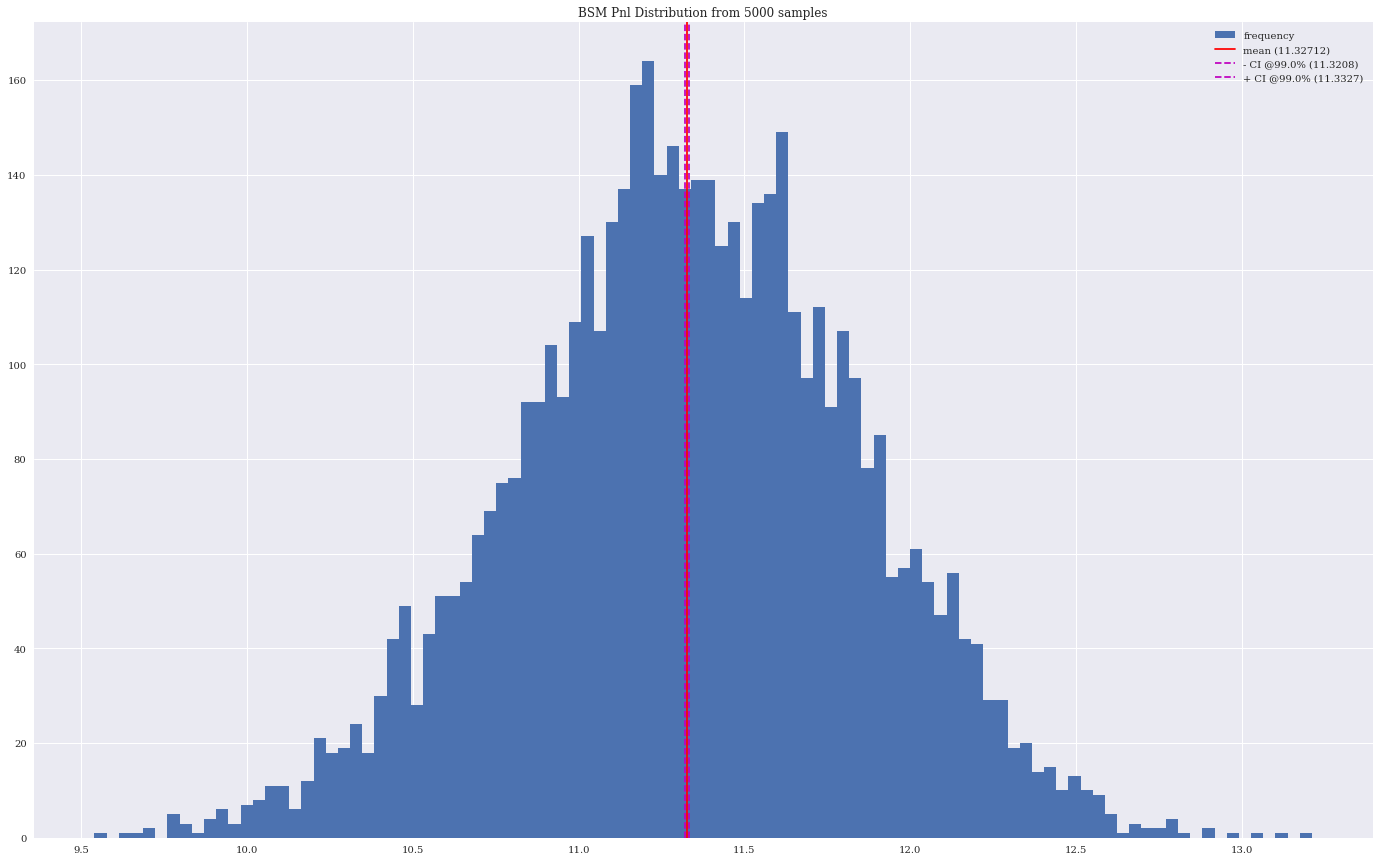

In [22]:

plt.figure(figsize=(24, 15))
# plt.hist(bsm_pnl_boot, bins=1000, label='frequency', range=[-S0*.01, S0*0.01]);
plt.hist(bsm_pnl_boot, bins=100, label='frequency');
# plt.hist(bsm_pnl_boot, bins=100, label='frequency', range=[-S0*.002, S0*0.002]);

plt.axvline(bsm_pnl_boot_mean, color='r', label=f"mean ({float('%.7g' % (bsm_pnl_boot_mean))})")
plt.axvline(bsm_pnl_boot_mean_ci_lo, color='m', label=f'- CI @{percentile*100}% ({(bsm_pnl_boot_mean_ci_lo).round(4)})', linestyle='--')
plt.axvline(bsm_pnl_boot_mean_ci_hi, color='m', label=f'+ CI @{percentile*100}% ({(bsm_pnl_boot_mean_ci_hi).round(4)})', linestyle='--')

plt.title(f'BSM Pnl Distribution from {N_boot} samples')
plt.legend(loc='best');
plt.show()

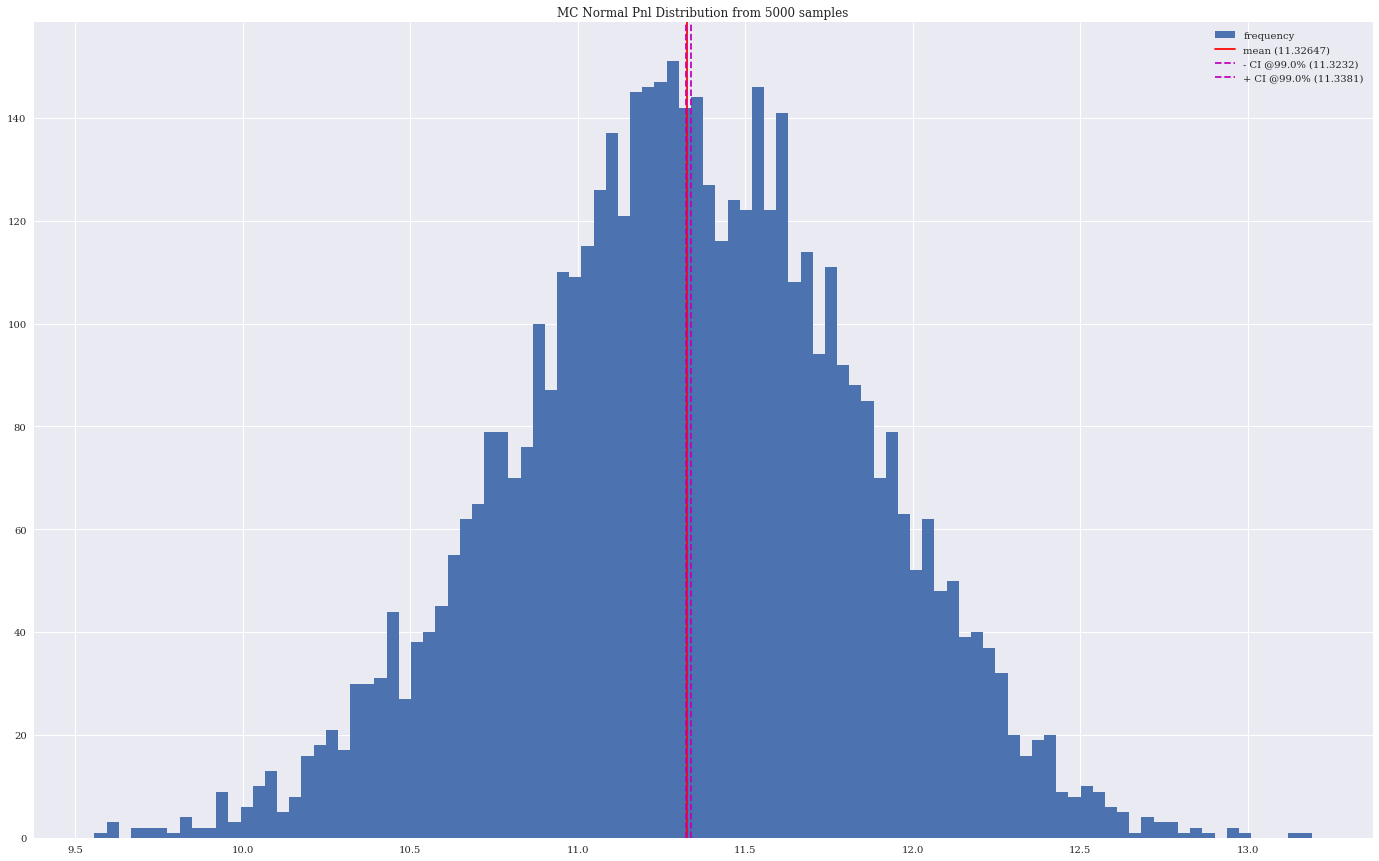

In [23]:


plt.figure(figsize=(24, 15))
# plt.hist(mc_normal_pnl_boot, bins=1000, label='frequency', range=[-S0*.01, S0*0.01]);
plt.hist(mc_normal_pnl_boot, bins=100, label='frequency');
# plt.hist(mc_normal_pnl_boot, bins=100, label='frequency', range=[-S0*.002, S0*0.002]);

plt.axvline(mc_normal_pnl_boot_mean, color='r', label=f"mean ({float('%.7g' % (mc_normal_pnl_boot_mean))})")
plt.axvline(mc_normal_pnl_boot_mean_ci_lo, color='m', label=f'- CI @{percentile*100}% ({(mc_normal_pnl_boot_mean_ci_lo).round(4)})', linestyle='--')
plt.axvline(mc_normal_pnl_boot_mean_ci_hi, color='m', label=f'+ CI @{percentile*100}% ({(mc_normal_pnl_boot_mean_ci_hi).round(4)})', linestyle='--')

plt.title(f'MC Normal Pnl Distribution from {N_boot} samples')
plt.legend(loc='best');
plt.show()

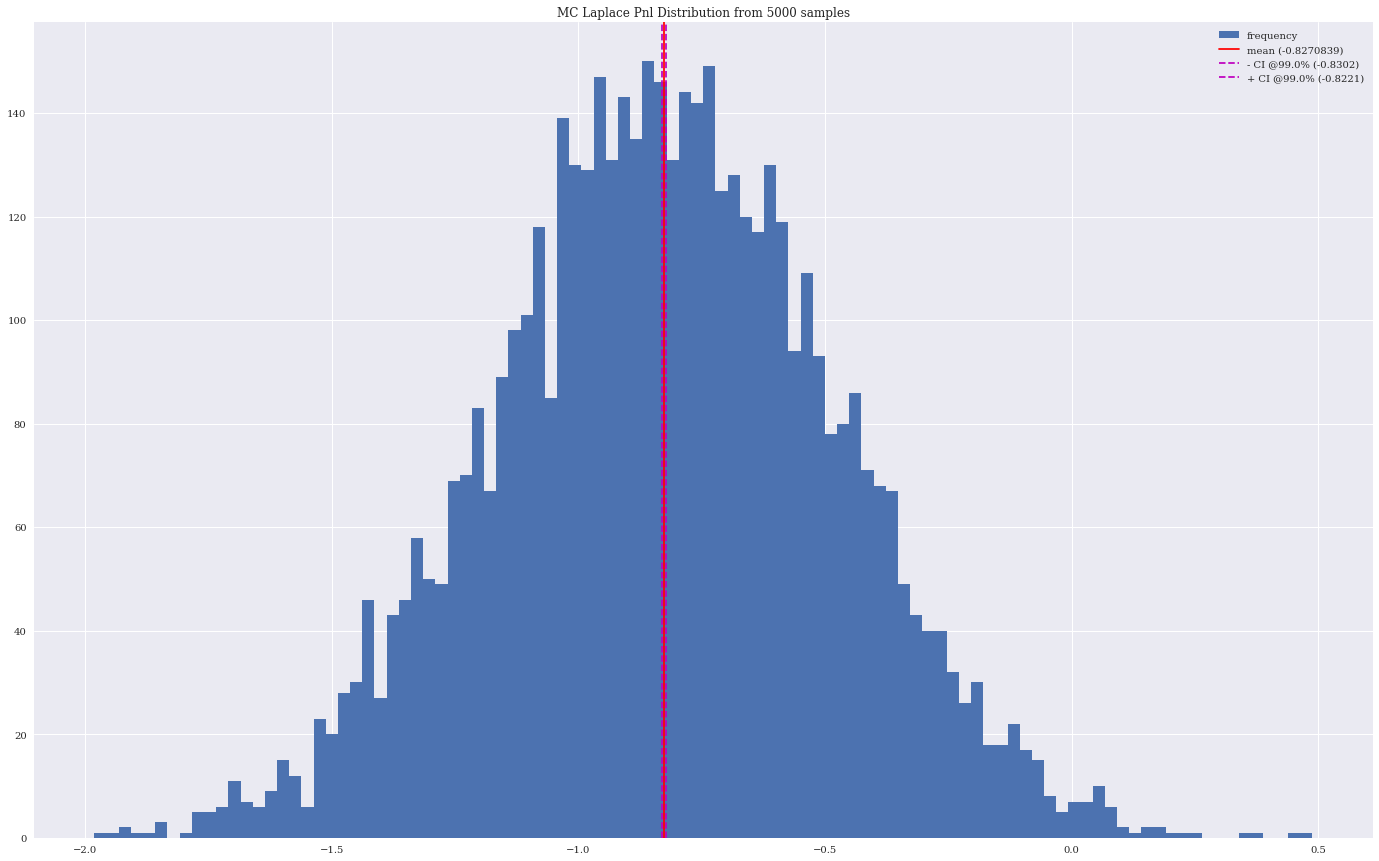

In [24]:

plt.figure(figsize=(24, 15))
# plt.hist(mc_laplace_pnl_boot, bins=1000, label='frequency', range=[-S0*.01, S0*0.01]);
plt.hist(mc_laplace_pnl_boot, bins=100, label='frequency');
# plt.hist(mc_laplace_pnl_boot, bins=100, label='frequency', range=[-S0*.002, S0*0.002]);

plt.axvline(mc_laplace_pnl_boot_mean, color='r', label=f"mean ({float('%.7g' % (mc_laplace_pnl_boot_mean))})")
plt.axvline(mc_laplace_pnl_boot_mean_ci_lo, color='m', label=f'- CI @{percentile*100}% ({(mc_laplace_pnl_boot_mean_ci_lo).round(4)})', linestyle='--')
plt.axvline(mc_laplace_pnl_boot_mean_ci_hi, color='m', label=f'+ CI @{percentile*100}% ({(mc_laplace_pnl_boot_mean_ci_hi).round(4)})', linestyle='--')

plt.title(f'MC Laplace Pnl Distribution from {N_boot} samples')
plt.legend(loc='best');
plt.show()

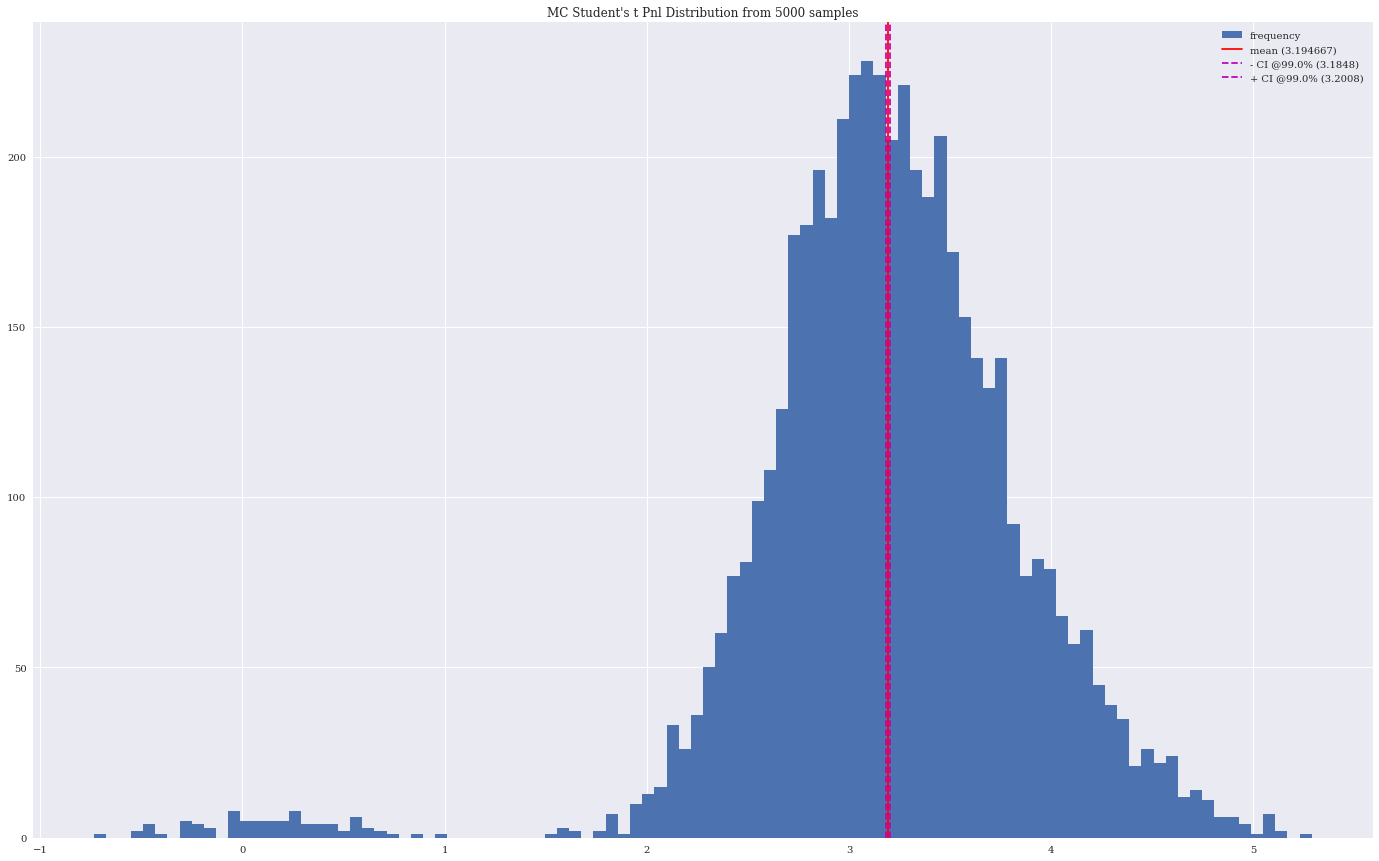

In [25]:

plt.figure(figsize=(24, 15))
# plt.hist(mc_student_t_pnl_boot, bins=1000, label='frequency', range=[-S0*.01, S0*0.01]);
plt.hist(mc_student_t_pnl_boot, bins=100, label='frequency');
# plt.hist(mc_student_t_pnl_boot, bins=100, label='frequency', range=[-S0*.002, S0*0.002]);

plt.axvline(mc_student_t_pnl_boot_mean, color='r', label=f"mean ({float('%.7g' % (mc_student_t_pnl_boot_mean))})")
plt.axvline(mc_student_t_pnl_boot_mean_ci_lo, color='m', label=f'- CI @{percentile*100}% ({(mc_student_t_pnl_boot_mean_ci_lo).round(4)})', linestyle='--')
plt.axvline(mc_student_t_pnl_boot_mean_ci_hi, color='m', label=f'+ CI @{percentile*100}% ({(mc_student_t_pnl_boot_mean_ci_hi).round(4)})', linestyle='--')

plt.title(f"MC Student's t Pnl Distribution from {N_boot} samples")
plt.legend(loc='best');
plt.show()